In [1]:
from oggm import cfg, utils, workflow, graphics
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shutil

In [2]:
cfg.initialize(logging_level='WARNING')

# Where to store the data
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-flowlines', reset=True)
cfg.PARAMS['store_model_geometry'] = True

2025-11-21 22:09:24: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-11-21 22:09:24: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-11-21 22:09:24: oggm.cfg: Multiprocessing: using all available processors (N=10)
2025-11-21 22:09:24: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


Define glaciers by RGI-IDs

In [3]:
# Which glaciers?
rgi_ids = ['RGI60-11.00897',    # HEF, AT
           'RGI60-13.21792'     # Pakhtakor, UZ
           ]

# We start from prepro level 3 with all data ready
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_base_url=base_url, prepro_border=80)

2025-11-21 22:09:24: oggm.workflow: init_glacier_directories from prepro level 3 on 2 glaciers.
2025-11-21 22:09:24: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers


Process each glacier:

- get outline as vector
- determine centerline
- determine flowline
- get flowline attribute as csv (coordinates, slope, ...)

**Note**: difference between OGGM centerline and flowline is described here: https://docs.oggm.org/en/stable/flowlines.html#pros-and-cons-of-both-methods

In [4]:
output_dir = utils.mkdir('outputs')

# process all glaciers
for gdir in gdirs:
    rgi_id = gdir.rgi_id

    tmp_output_dir = utils.mkdir('tmp_outputs')

    # get glacier outlines
    rgi = utils.get_rgi_region_file(region=gdir.rgi_region)
    gdf = gpd.read_file(rgi)
    gdf = gdf[gdf['RGIId'] == rgi_id]
    gdf.to_file(f"{output_dir}/{rgi_id}.gpkg", driver='GPKG', layer='outline')

    # determine centerlines
    fname = f"{tmp_output_dir}/{rgi_id}_centerlines.shp"
    utils.write_centerlines_to_shape(gdir, path=fname)
    shp = gpd.read_file(fname)
    shp.to_file(f"{output_dir}/{rgi_id}.gpkg", driver='GPKG', layer='centerlines')

    # determine flow lines
    fname = f"{tmp_output_dir}/{rgi_id}_flowlines.shp"
    utils.write_centerlines_to_shape(gdir, path=fname, flowlines_output=True)
    shp = gpd.read_file(fname)
    shp.to_file(f"{output_dir}/{rgi_id}.gpkg", driver='GPKG', layer='flowlines')

    # convert flowline data to csv
    fls = gdir.read_pickle('inversion_flowlines')

    fl = fls[-1]  # Main flowline
    i, j = fl.line.xy  # xy flowline on grid
    lons, lats = gdir.grid.ij_to_crs(i, j, crs='EPSG:4326')  # to WGS84
    dx = fl.dx * gdir.grid.dx

    # build data frame with important information
    df_coords = pd.DataFrame(index=(fl.dis_on_line*gdir.grid.dx).round(2))
    df_coords.index.name = 'Distance along flowline'
    df_coords['lon'] = lons
    df_coords['lat'] = lats
    df_coords['surface_height'] = fl.surface_h
    df_coords['slope_rad'] = np.arctan(-np.gradient(fl.surface_h, dx))
    df_coords['slope_deg'] = np.rad2deg(df_coords['slope_rad'])

    # export flowline data to csv
    df_coords.to_csv(f'{output_dir}/{rgi_id}_flowline.csv')

    # remove temp folder
    shutil.rmtree('tmp_outputs')

2025-11-21 22:09:25: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-11-21 22:09:25: oggm.utils: write_centerlines_to_shape on tmp_outputs/RGI60-11.00897_centerlines.shp ...
2025-11-21 22:09:25: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers
2025-11-21 22:09:25: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-11-21 22:09:25: oggm.utils: write_centerlines_to_shape on tmp_outputs/RGI60-11.00897_flowlines.shp ...
2025-11-21 22:09:25: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers
2025-11-21 22:09:26: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-11-21 22:09:26: oggm.utils: write_centerlines_to_shape on tmp_outputs/RGI60-13.21792_centerlines.shp ...
2025-11-21 22:09:26: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers
2025-11-21 22:09:26: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-11

Let's check the results:

- csv of flowline attributes
- show newly created vector files on map
- plot flowline attributes (height and slope)

In [5]:
gdir = gdirs[0]

df = pd.read_csv(output_dir+f'/{gdir.rgi_id}_flowline.csv')
display(df)

,Distance along flowline,lon,lat,surface_height,slope_rad,slope_deg
0,0.00,10.747036,46.803934,3429.088333,0.278718,15.969365
1,100.00,10.747036,46.803034,3400.471650,0.336206,19.263184
2,200.00,10.747036,46.802134,3359.193568,0.407746,23.362105
3,300.00,10.747036,46.801234,3314.080928,0.418929,24.002870
4,400.00,10.747037,46.800334,3270.135827,0.399363,22.881810
...,...,...,...,...,...,...
64,6397.35,10.798172,46.817113,2491.556700,0.118718,6.802052
65,6497.27,10.799315,46.817553,2481.090125,0.094317,5.403982
66,6597.16,10.800552,46.817846,2472.637109,0.089341,5.118876
67,6697.06,10.801747,46.818215,2463.174184,0.089927,5.152446


In [6]:
gdf_outline = gpd.read_file(output_dir+f'/{gdir.rgi_id}.gpkg', layer='outline')
gdf_flowline = gpd.read_file(output_dir+f'/{gdir.rgi_id}.gpkg', layer='flowlines')
gdf_centerline = gpd.read_file(output_dir+f'/{gdir.rgi_id}.gpkg', layer='centerlines')

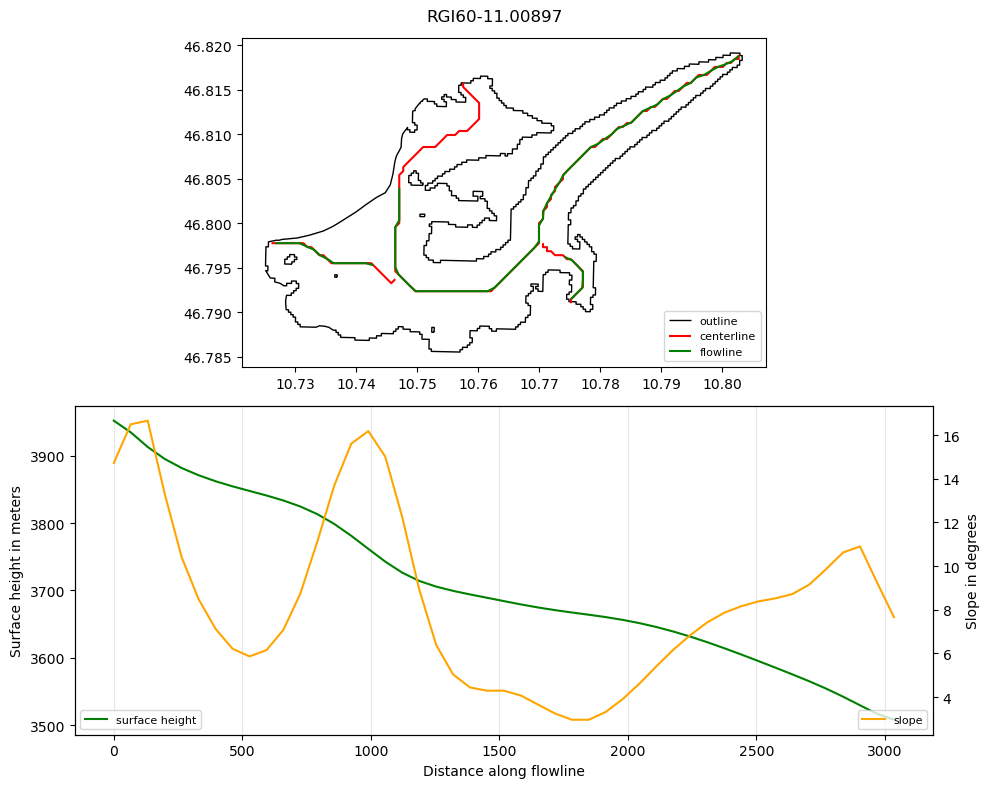

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

ax = axs[0]
gdf_outline.boundary.plot(ax=ax, label='outline', edgecolor='black', linewidth=1)
gdf_centerline.plot(ax=ax, label='centerline', color='red')
gdf_flowline.plot(ax=ax, label='flowline', color='green')
ax.legend(fontsize='8', loc='lower right')

ax = axs[1]
df_coords['surface_height'].plot(ax=ax, color='green', label='surface height')
ax.set_ylabel('Surface height in meters')
ax.legend(fontsize='8', loc='lower left')
ax.grid(alpha=0.3, axis='x')

axr = ax.twinx()
df_coords['slope_deg'].plot(ax=axr, color='orange', label='slope')
axr.set_ylabel('Slope in degrees')
axr.legend(fontsize='8', loc='lower right')

plt.suptitle(gdir.rgi_id)
plt.tight_layout()
plt.show()